In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cuda


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            print(self._path)   # 下划线不会影响使用，通常作为类内提示：用于类内名称
            print(filepath)
            with open(filepath) as fileobj:   # strip 去掉空格
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]
            # nrompath:规范化路径
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
            print(self._walker)
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
#             print(self._walker)
        if subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)  # 设置为集合
            self._walker = [w for w in self._walker if w not in excludes]  # 这里排除test和val中的文件。但这里self._walker怎么来的？


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")       
print(train_set)
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
waveform.shape  # torch.Size([1, 16000])
sample_rate  # 16000
# Conclusion 1:每一个频率都会对应一个tensor的值


### Conclude
#1. 音频文件是怎么变成tensor的？where self._walker in subset=='training' from?
#    自动转化，SubsetSC继承了父类SPEECHCOMMANDS，通过观察我们可以发现，子类中仅有一个初始化函数，在init中通过传入参数的不同，得到不同的
#self._walker，这是一个list。因此可以得出结论：子类中并没有函数对音频文件进行引入和处理。因此这个处理是在父类中自动进行的。同时，在training
#中在没有定义self._walker的情况下应用了self._walker，可以认为self._walker使父类中的变量，这个父类也是专门处理下载的这个数据集的。



./SpeechCommands\speech_commands_v0.02
./SpeechCommands\speech_commands_v0.02\validation_list.txt
./SpeechCommands\speech_commands_v0.02
./SpeechCommands\speech_commands_v0.02\testing_list.txt
./SpeechCommands\speech_commands_v0.02
./SpeechCommands\speech_commands_v0.02\testing_list.txt


16000

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


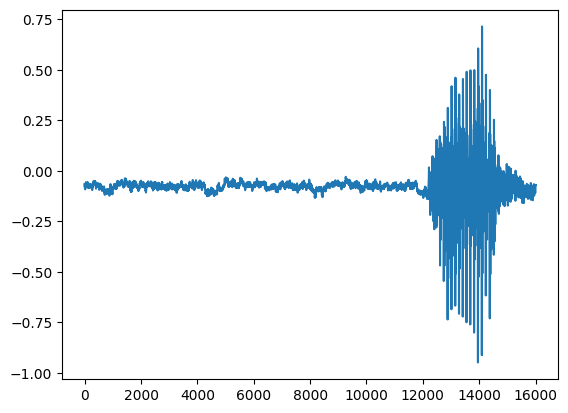

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [5]:
print(test_set[3])

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1090, -0.1430]]), 16000, 'right', 'fdb5155e', 2)


In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))  # 所有的类

labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [7]:
waveform_first, *_ = train_set[0]
print(waveform_first.shape)
ipd.Audio(waveform_first.numpy(), rate=sample_rate)  # tensor to numpy to video



torch.Size([1, 16000])


In [8]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [10]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [11]:
# SPEECHCOMMANDS 使用单声道音频，因此不需要减少通道  这里对train_set[0]进行转换
# 进行下采样   下采样是不是就是用一个较低的频率进行采样呢？
new_sample_rate = 8000
# orig_freq 音频的原始频率  new_freq 所需频率
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)
print(waveform.shape)
print(transformed.shape)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

torch.Size([1, 16000])
torch.Size([1, 8000])


In [12]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))    # 这里就一个数


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
print(type(index))
print(index)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

<class 'torch.Tensor'>
tensor(33)
yes --> tensor(33) --> yes


In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    # 用0填充，使一个batch有相同的长度
    batch = [item.t() for item in batch]  # 转置
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]   # 每个波形（tensor类型）加入到列表tensor中
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)   # 得到tensor的batch
    targets = torch.stack(targets)  # 连接，在新的维度进行堆叠   得到targets

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [14]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [16]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):   # 这里迭代返回的是data和target

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [17]:
for batch_idx, (data, target) in enumerate(train_loader):   # 这里迭代返回的是data和target
    print(data.shape)  # torch.Size([256, 1, 16000])  batchsize---256  train_data---[1, 16000]
    print(data)
    print(target.shape)   # 256 --- batchsize
    print(target)
    break

torch.Size([256, 1, 16000])
tensor([[[-1.4038e-03, -3.6926e-03, -2.2583e-03,  ..., -2.7466e-04,
          -1.2207e-03,  4.5776e-04]],

        [[ 0.0000e+00,  3.0518e-05,  3.0518e-05,  ...,  3.0518e-05,
          -3.0518e-05, -6.1035e-05]],

        [[ 3.9673e-04,  4.5776e-04,  3.6621e-04,  ...,  5.7983e-04,
           6.7139e-04,  1.1292e-03]],

        ...,

        [[-1.8311e-04, -3.3569e-04, -1.5259e-04,  ...,  1.2207e-04,
           2.7466e-04,  7.6294e-04]],

        [[-1.2817e-03, -2.2278e-03, -1.8311e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 6.1035e-05,  9.1553e-05,  6.1035e-05,  ...,  1.8311e-04,
           2.1362e-04,  1.8311e-04]]])
torch.Size([256])
tensor([13, 23, 33,  6, 27, 26, 33, 21, 33, 25, 10,  2, 22, 15, 12, 19, 10, 32,
        18, 18, 18, 15, 21, 33, 29, 23, 15,  3, 28, 33,  5,  7, 33,  9, 21,  9,
        26, 15, 25, 10, 27, 22, 29,  4, 26, 34, 26, 18, 20, 29,  6,  2, 33, 10,
        33, 34,  7, 25, 30, 16, 12, 11,  5,  7, 31, 34, 22

In [18]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):   # 匹配最接近的类别
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]E:\Anaconda_new\envs\pytorch\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                | 0.005333333333333333/5 [00:04<54:48, 658.42s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.826133


  1%|▊                                                                 | 0.05866666666666665/5 [00:08<05:03, 61.48s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.207224


  2%|█▍                                                                | 0.11199999999999995/5 [00:11<05:19, 65.43s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.513522


  3%|██▏                                                               | 0.16533333333333344/5 [00:14<04:47, 59.54s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.402256


  4%|██▉                                                                 | 0.218666666666667/5 [00:17<04:32, 57.08s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.156391


  5%|███▌                                                              | 0.27200000000000035/5 [00:21<04:44, 60.12s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.963423


  7%|████▎                                                             | 0.32533333333333336/5 [00:24<04:50, 62.08s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.987013


  8%|█████                                                              | 0.3786666666666664/5 [00:28<05:04, 65.84s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.627621


  9%|█████▊                                                             | 0.4319999999999994/5 [00:31<04:25, 58.03s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.698279


 10%|██████▌                                                            | 0.4853333333333324/5 [00:34<04:32, 60.29s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.653122


 11%|███████▏                                                           | 0.5386666666666662/5 [00:37<05:11, 69.87s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.438382


 12%|███████▉                                                           | 0.5920000000000003/5 [00:41<04:25, 60.29s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.243095


 13%|████████▋                                                          | 0.6453333333333344/5 [00:44<04:17, 59.21s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.326110


 14%|█████████▎                                                         | 0.6986666666666685/5 [00:47<04:04, 56.75s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.190620


 15%|██████████                                                         | 0.7520000000000027/5 [00:50<04:07, 58.26s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.091474


 16%|██████████▊                                                        | 0.8053333333333368/5 [00:54<04:24, 62.97s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.156863


 17%|███████████▌                                                       | 0.8586666666666709/5 [00:57<04:11, 60.74s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.304374


 20%|█████████████▍                                                     | 1.0000000000000062/5 [01:08<06:04, 91.03s/it]


Test Epoch: 1	Accuracy: 6213/11005 (56%)



 20%|█████████████▍                                                     | 1.0053333333333394/5 [01:09<05:13, 78.60s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.136933


 21%|██████████████▏                                                    | 1.0586666666666713/5 [01:13<04:41, 71.52s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.000433


 22%|██████████████▉                                                    | 1.1120000000000032/5 [01:16<04:20, 66.92s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.042981


 23%|███████████████▊                                                    | 1.165333333333335/5 [01:20<03:56, 61.72s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.077928


 24%|████████████████▌                                                   | 1.218666666666667/5 [01:23<03:46, 59.86s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.064986


 25%|█████████████████▎                                                  | 1.271999999999999/5 [01:27<04:01, 64.89s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.938043


 27%|█████████████████▊                                                 | 1.3253333333333308/5 [01:30<03:29, 56.93s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.992383


 28%|██████████████████▍                                                | 1.3786666666666627/5 [01:34<03:46, 62.68s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.953713


 29%|███████████████████▏                                               | 1.4319999999999946/5 [01:37<03:46, 63.51s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.847769


 30%|███████████████████▉                                               | 1.4853333333333265/5 [01:41<03:57, 67.49s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 1.128756


 31%|████████████████████▌                                              | 1.5386666666666584/5 [01:44<03:40, 63.79s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.901990


 32%|█████████████████████▎                                             | 1.5919999999999903/5 [01:47<03:38, 64.22s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 1.022612


 33%|██████████████████████                                             | 1.6453333333333222/5 [01:51<03:39, 65.37s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.944749


 34%|██████████████████████▊                                            | 1.6986666666666541/5 [01:55<03:48, 69.23s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 1.084331


 35%|███████████████████████▊                                            | 1.751999999999986/5 [01:58<03:19, 61.45s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.958429


 36%|████████████████████████▌                                           | 1.805333333333318/5 [02:02<03:37, 68.11s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.875814


 37%|████████████████████████▊                                          | 1.8559999999999832/5 [02:05<03:58, 75.87s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 1.034683


 40%|██████████████████████████▊                                        | 1.9999999999999793/5 [02:15<03:15, 65.12s/it]


Test Epoch: 2	Accuracy: 7456/11005 (68%)



 40%|██████████████████████████▊                                        | 2.0053333333333128/5 [02:15<03:22, 67.60s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.810385


 41%|███████████████████████████▉                                        | 2.058666666666649/5 [02:19<03:03, 62.56s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.741427


 42%|████████████████████████████▎                                      | 2.1119999999999854/5 [02:23<03:12, 66.65s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.807488


 43%|█████████████████████████████▍                                      | 2.165333333333322/5 [02:26<02:57, 62.52s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.778426


 44%|██████████████████████████████▏                                     | 2.218666666666658/5 [02:29<02:41, 58.00s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.875293


 45%|██████████████████████████████▍                                    | 2.2719999999999945/5 [02:33<02:43, 60.10s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.849184


 47%|███████████████████████████████▌                                    | 2.325333333333331/5 [02:36<02:43, 61.22s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.830493


 48%|████████████████████████████████▎                                   | 2.378666666666667/5 [02:40<02:52, 65.83s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.889097


 49%|████████████████████████████████▌                                  | 2.4320000000000035/5 [02:44<02:55, 68.39s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.987462


 50%|██████████████████████████████████▎                                  | 2.48533333333334/5 [02:47<02:28, 59.11s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.757096


 51%|██████████████████████████████████▌                                 | 2.538666666666676/5 [02:50<02:34, 62.60s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.830453


 52%|██████████████████████████████████▋                                | 2.5920000000000125/5 [02:54<02:57, 73.80s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.808803


 53%|███████████████████████████████████▉                                | 2.645333333333349/5 [02:58<02:41, 68.61s/it]

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.965253


 54%|████████████████████████████████████▋                               | 2.698666666666685/5 [03:02<02:39, 69.34s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.731586


 55%|████████████████████████████████████▉                              | 2.7520000000000215/5 [03:05<02:26, 65.39s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.998761


 56%|██████████████████████████████████████▏                             | 2.805333333333358/5 [03:09<02:09, 59.17s/it]

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.726044


 57%|██████████████████████████████████████▎                            | 2.8586666666666942/5 [03:12<02:16, 63.88s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.769709


 60%|████████████████████████████████████████▏                          | 3.0000000000000355/5 [03:21<02:08, 64.35s/it]


Test Epoch: 3	Accuracy: 8290/11005 (75%)



 60%|████████████████████████████████████████▊                           | 3.005333333333369/5 [03:21<02:12, 66.52s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.709506


 61%|████████████████████████████████████████▉                          | 3.0586666666667055/5 [03:25<02:08, 66.05s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.680838


 62%|██████████████████████████████████████████▎                         | 3.112000000000042/5 [03:28<02:06, 66.89s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.835193


 63%|███████████████████████████████████████████                         | 3.165333333333378/5 [03:32<01:53, 61.92s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.744048


 64%|███████████████████████████████████████████▏                       | 3.2186666666667145/5 [03:35<01:41, 57.00s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.734483


 65%|████████████████████████████████████████████▍                       | 3.272000000000051/5 [03:39<01:56, 67.34s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.713317


 67%|█████████████████████████████████████████████▏                      | 3.325333333333387/5 [03:42<01:41, 60.67s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.668709


 68%|█████████████████████████████████████████████▎                     | 3.3786666666667236/5 [03:45<01:37, 60.14s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.867162


 69%|███████████████████████████████████████████████▎                     | 3.43200000000006/5 [03:49<01:45, 67.19s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.684586


 70%|██████████████████████████████████████████████▋                    | 3.4853333333333962/5 [03:52<01:41, 66.77s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.852687


 71%|███████████████████████████████████████████████▍                   | 3.5386666666667326/5 [03:56<01:31, 62.86s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.923474


 72%|████████████████████████████████████████████████▊                   | 3.592000000000069/5 [04:00<02:00, 85.91s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.716012


 73%|████████████████████████████████████████████████▊                  | 3.6453333333334053/5 [04:04<01:45, 78.05s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.648450


 74%|█████████████████████████████████████████████████▌                 | 3.6986666666667416/5 [04:08<01:18, 60.02s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.661259


 75%|███████████████████████████████████████████████████                 | 3.752000000000078/5 [04:11<01:17, 62.01s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.633879


 76%|██████████████████████████████████████████████████▉                | 3.8053333333334143/5 [04:15<01:21, 68.54s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.840491


 77%|███████████████████████████████████████████████████▋               | 3.8586666666667506/5 [04:18<01:13, 64.07s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.786860


 80%|█████████████████████████████████████████████████████▌             | 4.0000000000000915/5 [04:27<01:03, 63.26s/it]


Test Epoch: 4	Accuracy: 8504/11005 (77%)



 80%|██████████████████████████████████████████████████████▍             | 4.005333333333424/5 [04:27<01:04, 65.22s/it]

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.590969


 81%|███████████████████████████████████████████████████████▏            | 4.058666666666752/5 [04:31<00:58, 61.66s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.595078


 82%|███████████████████████████████████████████████████████▉            | 4.112000000000079/5 [04:35<01:01, 68.99s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.808065


 83%|████████████████████████████████████████████████████████▋           | 4.165333333333407/5 [04:38<00:52, 62.42s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.793864


 84%|█████████████████████████████████████████████████████████▎          | 4.218666666666734/5 [04:41<00:48, 62.38s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.662639


 85%|█████████████████████████████████████████████████████████▏         | 4.2720000000000615/5 [04:45<00:50, 69.47s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.575882


 87%|██████████████████████████████████████████████████████████▊         | 4.325333333333389/5 [04:49<00:46, 68.71s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.797634


 88%|██████████████████████████████████████████████████████████▋        | 4.3786666666667164/5 [04:53<00:42, 68.40s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.652575


 89%|████████████████████████████████████████████████████████████▎       | 4.432000000000044/5 [04:56<00:34, 61.49s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.609909


 90%|█████████████████████████████████████████████████████████████       | 4.485333333333371/5 [04:59<00:31, 60.28s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.593704


 91%|█████████████████████████████████████████████████████████████▋      | 4.538666666666699/5 [05:03<00:29, 64.96s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.602273


 92%|██████████████████████████████████████████████████████████████▍     | 4.592000000000026/5 [05:07<00:25, 62.75s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.582136


 93%|███████████████████████████████████████████████████████████████▏    | 4.645333333333354/5 [05:10<00:22, 63.59s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.607338


 94%|███████████████████████████████████████████████████████████████▉    | 4.698666666666681/5 [05:14<00:20, 67.49s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.691256


 95%|████████████████████████████████████████████████████████████████▋   | 4.752000000000009/5 [05:17<00:17, 70.66s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.705766


 96%|█████████████████████████████████████████████████████████████████▎  | 4.805333333333336/5 [05:21<00:13, 71.32s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.714006


 97%|██████████████████████████████████████████████████████████████████  | 4.858666666666664/5 [05:25<00:09, 64.54s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.545410


100%|███████████████████████████████████████████████████████████████████▉| 4.999999999999981/5 [05:34<00:00, 66.94s/it]



Test Epoch: 5	Accuracy: 8435/11005 (77%)



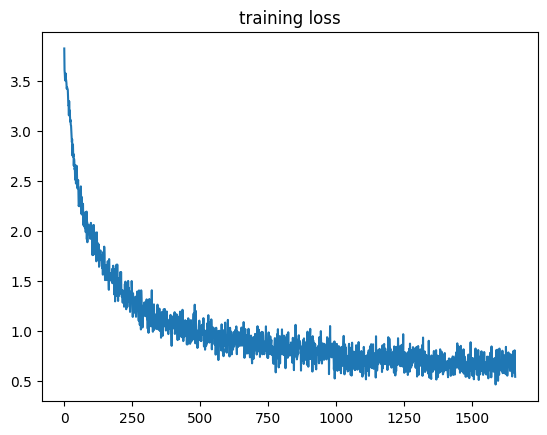

In [19]:
log_interval = 20
n_epoch = 5

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [20]:
# log_interval = 20
# n_epoch = 2

# pbar_update = 1 / (len(train_loader) + len(test_loader))
# losses = []

# # The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
# with tqdm(total=n_epoch) as pbar:
#     for epoch in range(1, n_epoch + 1):
#         train(model, epoch, log_interval)
#         test(model, epoch)
#         scheduler.step()

# # Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

In [21]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)  # 使用一个音频信号的tensor进行检测
#     print('before',tensor.shape)
    tensor = transform(tensor)  # transform定义中，固定了ori_fre = 16000 不具有普适性，因此输入的tensor要求频率为16000
#     print('after transform', tensor.shape)
#     print('tensor.unsqueeze(0)', tensor.unsqueeze(0).shape)
    
    ##########  问题解决   #####################
    tensor = model(tensor.unsqueeze(0))  # 将tensor在0的位置加一个维度，模拟batch_size的值
#     print('model处理后的',tensor.shape)
#     print('model处理后的',tensor)
    tensor = get_likely_index(tensor)   # 得到最可能的一个tensor
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]     # 使用train_set的进行预测，这里是为什么？应该使用test的的吧
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [22]:
wrong = 0
right = 0
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    if waveform.shape[1] != 16000:
        continue
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"#####Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        wrong += 1
        
    else:
#         print("All examples in this dataset were correctly classified!")
#         print("In this case, let's just look at the last data point")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        right += 1
        print(f"!!!!!Data point #{i}. Expected: {utterance}. Predicted: {output}.")

!!!!!Data point #0. Expected: right. Predicted: right.
#####Data point #1. Expected: right. Predicted: seven.
!!!!!Data point #2. Expected: right. Predicted: right.
#####Data point #4. Expected: right. Predicted: five.
!!!!!Data point #5. Expected: right. Predicted: right.
!!!!!Data point #6. Expected: right. Predicted: right.
!!!!!Data point #7. Expected: right. Predicted: right.
!!!!!Data point #8. Expected: right. Predicted: right.
#####Data point #9. Expected: right. Predicted: four.
#####Data point #10. Expected: right. Predicted: five.
#####Data point #11. Expected: right. Predicted: follow.
!!!!!Data point #12. Expected: right. Predicted: right.
!!!!!Data point #13. Expected: right. Predicted: right.
!!!!!Data point #14. Expected: right. Predicted: right.
!!!!!Data point #15. Expected: right. Predicted: right.
#####Data point #16. Expected: right. Predicted: one.
!!!!!Data point #17. Expected: right. Predicted: right.
!!!!!Data point #18. Expected: right. Predicted: right.
#####

#####Data point #221. Expected: right. Predicted: bed.
#####Data point #222. Expected: right. Predicted: five.
!!!!!Data point #223. Expected: right. Predicted: right.
#####Data point #224. Expected: right. Predicted: one.
!!!!!Data point #225. Expected: right. Predicted: right.
!!!!!Data point #226. Expected: right. Predicted: right.
!!!!!Data point #227. Expected: right. Predicted: right.
#####Data point #228. Expected: right. Predicted: one.
!!!!!Data point #229. Expected: right. Predicted: right.
!!!!!Data point #230. Expected: right. Predicted: right.
#####Data point #231. Expected: right. Predicted: no.
!!!!!Data point #232. Expected: right. Predicted: right.
!!!!!Data point #233. Expected: right. Predicted: right.
#####Data point #234. Expected: right. Predicted: bird.
!!!!!Data point #235. Expected: right. Predicted: right.
!!!!!Data point #236. Expected: right. Predicted: right.
!!!!!Data point #237. Expected: right. Predicted: right.
!!!!!Data point #238. Expected: right. Pre

!!!!!Data point #416. Expected: eight. Predicted: eight.
!!!!!Data point #417. Expected: eight. Predicted: eight.
!!!!!Data point #418. Expected: eight. Predicted: eight.
!!!!!Data point #419. Expected: eight. Predicted: eight.
!!!!!Data point #420. Expected: eight. Predicted: eight.
!!!!!Data point #421. Expected: eight. Predicted: eight.
!!!!!Data point #422. Expected: eight. Predicted: eight.
!!!!!Data point #423. Expected: eight. Predicted: eight.
!!!!!Data point #424. Expected: eight. Predicted: eight.
#####Data point #425. Expected: eight. Predicted: two.
!!!!!Data point #426. Expected: eight. Predicted: eight.
#####Data point #427. Expected: eight. Predicted: two.
!!!!!Data point #429. Expected: eight. Predicted: eight.
#####Data point #430. Expected: eight. Predicted: go.
#####Data point #431. Expected: eight. Predicted: two.
!!!!!Data point #432. Expected: eight. Predicted: eight.
!!!!!Data point #434. Expected: eight. Predicted: eight.
!!!!!Data point #435. Expected: eight. P

!!!!!Data point #624. Expected: eight. Predicted: eight.
#####Data point #625. Expected: eight. Predicted: no.
!!!!!Data point #626. Expected: eight. Predicted: eight.
!!!!!Data point #627. Expected: eight. Predicted: eight.
!!!!!Data point #628. Expected: eight. Predicted: eight.
!!!!!Data point #629. Expected: eight. Predicted: eight.
!!!!!Data point #630. Expected: eight. Predicted: eight.
!!!!!Data point #631. Expected: eight. Predicted: eight.
!!!!!Data point #632. Expected: eight. Predicted: eight.
!!!!!Data point #633. Expected: eight. Predicted: eight.
!!!!!Data point #634. Expected: eight. Predicted: eight.
!!!!!Data point #635. Expected: eight. Predicted: eight.
#####Data point #636. Expected: eight. Predicted: no.
!!!!!Data point #637. Expected: eight. Predicted: eight.
!!!!!Data point #638. Expected: eight. Predicted: eight.
#####Data point #639. Expected: eight. Predicted: two.
!!!!!Data point #640. Expected: eight. Predicted: eight.
!!!!!Data point #641. Expected: eight. 

!!!!!Data point #847. Expected: cat. Predicted: cat.
!!!!!Data point #848. Expected: cat. Predicted: cat.
!!!!!Data point #849. Expected: cat. Predicted: cat.
#####Data point #850. Expected: cat. Predicted: bed.
#####Data point #851. Expected: cat. Predicted: stop.
#####Data point #852. Expected: cat. Predicted: five.
!!!!!Data point #853. Expected: cat. Predicted: cat.
!!!!!Data point #854. Expected: cat. Predicted: cat.
!!!!!Data point #855. Expected: cat. Predicted: cat.
#####Data point #856. Expected: cat. Predicted: go.
!!!!!Data point #857. Expected: cat. Predicted: cat.
!!!!!Data point #858. Expected: cat. Predicted: cat.
!!!!!Data point #859. Expected: cat. Predicted: cat.
#####Data point #860. Expected: cat. Predicted: go.
!!!!!Data point #861. Expected: cat. Predicted: cat.
!!!!!Data point #862. Expected: cat. Predicted: cat.
!!!!!Data point #863. Expected: cat. Predicted: cat.
#####Data point #864. Expected: cat. Predicted: house.
!!!!!Data point #865. Expected: cat. Predict

!!!!!Data point #1064. Expected: tree. Predicted: tree.
#####Data point #1065. Expected: tree. Predicted: two.
!!!!!Data point #1066. Expected: tree. Predicted: tree.
!!!!!Data point #1068. Expected: tree. Predicted: tree.
!!!!!Data point #1069. Expected: tree. Predicted: tree.
!!!!!Data point #1070. Expected: tree. Predicted: tree.
!!!!!Data point #1071. Expected: tree. Predicted: tree.
#####Data point #1072. Expected: tree. Predicted: two.
#####Data point #1073. Expected: tree. Predicted: follow.
#####Data point #1074. Expected: tree. Predicted: three.
!!!!!Data point #1075. Expected: tree. Predicted: tree.
#####Data point #1076. Expected: tree. Predicted: three.
!!!!!Data point #1077. Expected: tree. Predicted: tree.
!!!!!Data point #1078. Expected: tree. Predicted: tree.
!!!!!Data point #1080. Expected: tree. Predicted: tree.
!!!!!Data point #1081. Expected: tree. Predicted: tree.
!!!!!Data point #1082. Expected: tree. Predicted: tree.
#####Data point #1083. Expected: tree. Predict

#####Data point #1286. Expected: backward. Predicted: bird.
!!!!!Data point #1287. Expected: backward. Predicted: backward.
!!!!!Data point #1288. Expected: backward. Predicted: backward.
!!!!!Data point #1289. Expected: backward. Predicted: backward.
!!!!!Data point #1290. Expected: backward. Predicted: backward.
!!!!!Data point #1291. Expected: backward. Predicted: backward.
!!!!!Data point #1292. Expected: backward. Predicted: backward.
!!!!!Data point #1293. Expected: backward. Predicted: backward.
!!!!!Data point #1294. Expected: backward. Predicted: backward.
!!!!!Data point #1295. Expected: backward. Predicted: backward.
!!!!!Data point #1296. Expected: backward. Predicted: backward.
!!!!!Data point #1297. Expected: backward. Predicted: backward.
#####Data point #1298. Expected: backward. Predicted: down.
#####Data point #1299. Expected: backward. Predicted: down.
!!!!!Data point #1300. Expected: backward. Predicted: backward.
!!!!!Data point #1301. Expected: backward. Predicted

#####Data point #1505. Expected: learn. Predicted: five.
#####Data point #1506. Expected: learn. Predicted: go.
#####Data point #1507. Expected: learn. Predicted: one.
#####Data point #1509. Expected: learn. Predicted: yes.
!!!!!Data point #1510. Expected: learn. Predicted: learn.
!!!!!Data point #1511. Expected: learn. Predicted: learn.
#####Data point #1512. Expected: learn. Predicted: no.
#####Data point #1513. Expected: learn. Predicted: no.
!!!!!Data point #1515. Expected: learn. Predicted: learn.
!!!!!Data point #1516. Expected: learn. Predicted: learn.
#####Data point #1517. Expected: bed. Predicted: eight.
!!!!!Data point #1518. Expected: bed. Predicted: bed.
!!!!!Data point #1519. Expected: bed. Predicted: bed.
#####Data point #1520. Expected: bed. Predicted: go.
#####Data point #1521. Expected: bed. Predicted: bird.
!!!!!Data point #1523. Expected: bed. Predicted: bed.
#####Data point #1524. Expected: bed. Predicted: seven.
!!!!!Data point #1525. Expected: bed. Predicted: bed

!!!!!Data point #1724. Expected: happy. Predicted: happy.
!!!!!Data point #1725. Expected: happy. Predicted: happy.
!!!!!Data point #1726. Expected: happy. Predicted: happy.
!!!!!Data point #1727. Expected: happy. Predicted: happy.
!!!!!Data point #1728. Expected: happy. Predicted: happy.
!!!!!Data point #1729. Expected: happy. Predicted: happy.
!!!!!Data point #1730. Expected: happy. Predicted: happy.
#####Data point #1731. Expected: happy. Predicted: six.
!!!!!Data point #1732. Expected: happy. Predicted: happy.
!!!!!Data point #1733. Expected: happy. Predicted: happy.
!!!!!Data point #1734. Expected: happy. Predicted: happy.
!!!!!Data point #1735. Expected: happy. Predicted: happy.
!!!!!Data point #1736. Expected: happy. Predicted: happy.
!!!!!Data point #1737. Expected: happy. Predicted: happy.
!!!!!Data point #1738. Expected: happy. Predicted: happy.
!!!!!Data point #1739. Expected: happy. Predicted: happy.
!!!!!Data point #1740. Expected: happy. Predicted: happy.
!!!!!Data point 

#####Data point #1935. Expected: go. Predicted: one.
!!!!!Data point #1936. Expected: go. Predicted: go.
!!!!!Data point #1937. Expected: go. Predicted: go.
!!!!!Data point #1938. Expected: go. Predicted: go.
!!!!!Data point #1939. Expected: go. Predicted: go.
!!!!!Data point #1940. Expected: go. Predicted: go.
!!!!!Data point #1941. Expected: go. Predicted: go.
!!!!!Data point #1942. Expected: go. Predicted: go.
!!!!!Data point #1943. Expected: go. Predicted: go.
!!!!!Data point #1944. Expected: go. Predicted: go.
#####Data point #1945. Expected: go. Predicted: down.
!!!!!Data point #1946. Expected: go. Predicted: go.
!!!!!Data point #1948. Expected: go. Predicted: go.
!!!!!Data point #1949. Expected: go. Predicted: go.
!!!!!Data point #1950. Expected: go. Predicted: go.
!!!!!Data point #1951. Expected: go. Predicted: go.
#####Data point #1952. Expected: go. Predicted: no.
!!!!!Data point #1953. Expected: go. Predicted: go.
!!!!!Data point #1954. Expected: go. Predicted: go.
!!!!!Data

#####Data point #2148. Expected: go. Predicted: bird.
!!!!!Data point #2149. Expected: go. Predicted: go.
!!!!!Data point #2150. Expected: go. Predicted: go.
!!!!!Data point #2151. Expected: go. Predicted: go.
!!!!!Data point #2152. Expected: go. Predicted: go.
!!!!!Data point #2153. Expected: go. Predicted: go.
!!!!!Data point #2154. Expected: go. Predicted: go.
!!!!!Data point #2155. Expected: go. Predicted: go.
!!!!!Data point #2156. Expected: go. Predicted: go.
!!!!!Data point #2157. Expected: go. Predicted: go.
!!!!!Data point #2158. Expected: go. Predicted: go.
!!!!!Data point #2159. Expected: go. Predicted: go.
!!!!!Data point #2160. Expected: go. Predicted: go.
!!!!!Data point #2161. Expected: go. Predicted: go.
#####Data point #2163. Expected: go. Predicted: five.
!!!!!Data point #2164. Expected: go. Predicted: go.
!!!!!Data point #2165. Expected: go. Predicted: go.
!!!!!Data point #2166. Expected: go. Predicted: go.
!!!!!Data point #2167. Expected: go. Predicted: go.
!!!!!Dat

!!!!!Data point #2371. Expected: dog. Predicted: dog.
!!!!!Data point #2372. Expected: dog. Predicted: dog.
!!!!!Data point #2373. Expected: dog. Predicted: dog.
!!!!!Data point #2374. Expected: dog. Predicted: dog.
#####Data point #2375. Expected: dog. Predicted: stop.
!!!!!Data point #2376. Expected: dog. Predicted: dog.
!!!!!Data point #2377. Expected: dog. Predicted: dog.
!!!!!Data point #2378. Expected: dog. Predicted: dog.
#####Data point #2379. Expected: dog. Predicted: two.
#####Data point #2380. Expected: dog. Predicted: down.
!!!!!Data point #2381. Expected: dog. Predicted: dog.
#####Data point #2383. Expected: dog. Predicted: go.
!!!!!Data point #2384. Expected: dog. Predicted: dog.
#####Data point #2385. Expected: dog. Predicted: down.
!!!!!Data point #2386. Expected: dog. Predicted: dog.
!!!!!Data point #2387. Expected: dog. Predicted: dog.
#####Data point #2388. Expected: dog. Predicted: go.
!!!!!Data point #2389. Expected: dog. Predicted: dog.
#####Data point #2390. Expe

!!!!!Data point #2599. Expected: no. Predicted: no.
!!!!!Data point #2600. Expected: no. Predicted: no.
#####Data point #2601. Expected: no. Predicted: go.
!!!!!Data point #2602. Expected: no. Predicted: no.
#####Data point #2603. Expected: no. Predicted: nine.
!!!!!Data point #2604. Expected: no. Predicted: no.
!!!!!Data point #2605. Expected: no. Predicted: no.
!!!!!Data point #2606. Expected: no. Predicted: no.
!!!!!Data point #2607. Expected: no. Predicted: no.
!!!!!Data point #2608. Expected: no. Predicted: no.
!!!!!Data point #2609. Expected: no. Predicted: no.
!!!!!Data point #2610. Expected: no. Predicted: no.
!!!!!Data point #2611. Expected: no. Predicted: no.
!!!!!Data point #2613. Expected: no. Predicted: no.
!!!!!Data point #2615. Expected: no. Predicted: no.
!!!!!Data point #2616. Expected: no. Predicted: no.
!!!!!Data point #2617. Expected: no. Predicted: no.
!!!!!Data point #2618. Expected: no. Predicted: no.
#####Data point #2619. Expected: no. Predicted: down.
!!!!!Dat

!!!!!Data point #2802. Expected: no. Predicted: no.
!!!!!Data point #2803. Expected: no. Predicted: no.
!!!!!Data point #2805. Expected: no. Predicted: no.
!!!!!Data point #2806. Expected: no. Predicted: no.
!!!!!Data point #2807. Expected: no. Predicted: no.
#####Data point #2808. Expected: no. Predicted: down.
!!!!!Data point #2809. Expected: no. Predicted: no.
#####Data point #2810. Expected: no. Predicted: go.
!!!!!Data point #2811. Expected: no. Predicted: no.
!!!!!Data point #2812. Expected: no. Predicted: no.
!!!!!Data point #2813. Expected: no. Predicted: no.
!!!!!Data point #2814. Expected: no. Predicted: no.
!!!!!Data point #2815. Expected: no. Predicted: no.
!!!!!Data point #2816. Expected: no. Predicted: no.
!!!!!Data point #2817. Expected: no. Predicted: no.
!!!!!Data point #2818. Expected: no. Predicted: no.
#####Data point #2819. Expected: no. Predicted: stop.
!!!!!Data point #2820. Expected: no. Predicted: no.
!!!!!Data point #2821. Expected: no. Predicted: no.
#####Dat

!!!!!Data point #3021. Expected: wow. Predicted: wow.
#####Data point #3022. Expected: wow. Predicted: no.
!!!!!Data point #3023. Expected: wow. Predicted: wow.
#####Data point #3025. Expected: wow. Predicted: go.
!!!!!Data point #3026. Expected: wow. Predicted: wow.
#####Data point #3027. Expected: wow. Predicted: no.
!!!!!Data point #3028. Expected: wow. Predicted: wow.
!!!!!Data point #3029. Expected: wow. Predicted: wow.
#####Data point #3030. Expected: wow. Predicted: one.
#####Data point #3031. Expected: wow. Predicted: down.
!!!!!Data point #3032. Expected: wow. Predicted: wow.
!!!!!Data point #3033. Expected: wow. Predicted: wow.
#####Data point #3037. Expected: wow. Predicted: no.
!!!!!Data point #3038. Expected: wow. Predicted: wow.
!!!!!Data point #3039. Expected: wow. Predicted: wow.
!!!!!Data point #3040. Expected: wow. Predicted: wow.
!!!!!Data point #3042. Expected: wow. Predicted: wow.
#####Data point #3044. Expected: wow. Predicted: one.
!!!!!Data point #3046. Expected

!!!!!Data point #3256. Expected: follow. Predicted: follow.
#####Data point #3257. Expected: follow. Predicted: four.
!!!!!Data point #3258. Expected: follow. Predicted: follow.
!!!!!Data point #3259. Expected: follow. Predicted: follow.
!!!!!Data point #3260. Expected: follow. Predicted: follow.
#####Data point #3261. Expected: follow. Predicted: four.
!!!!!Data point #3262. Expected: follow. Predicted: follow.
!!!!!Data point #3263. Expected: follow. Predicted: follow.
#####Data point #3264. Expected: follow. Predicted: on.
!!!!!Data point #3265. Expected: follow. Predicted: follow.
!!!!!Data point #3266. Expected: follow. Predicted: follow.
!!!!!Data point #3267. Expected: follow. Predicted: follow.
!!!!!Data point #3268. Expected: follow. Predicted: follow.
!!!!!Data point #3269. Expected: follow. Predicted: follow.
!!!!!Data point #3270. Expected: follow. Predicted: follow.
!!!!!Data point #3271. Expected: follow. Predicted: follow.
#####Data point #3272. Expected: follow. Predict

!!!!!Data point #3473. Expected: nine. Predicted: nine.
!!!!!Data point #3474. Expected: nine. Predicted: nine.
!!!!!Data point #3475. Expected: nine. Predicted: nine.
!!!!!Data point #3476. Expected: nine. Predicted: nine.
!!!!!Data point #3478. Expected: nine. Predicted: nine.
!!!!!Data point #3479. Expected: nine. Predicted: nine.
!!!!!Data point #3481. Expected: nine. Predicted: nine.
#####Data point #3482. Expected: nine. Predicted: no.
!!!!!Data point #3483. Expected: nine. Predicted: nine.
!!!!!Data point #3484. Expected: nine. Predicted: nine.
!!!!!Data point #3485. Expected: nine. Predicted: nine.
#####Data point #3486. Expected: nine. Predicted: down.
!!!!!Data point #3487. Expected: nine. Predicted: nine.
#####Data point #3488. Expected: nine. Predicted: down.
#####Data point #3489. Expected: nine. Predicted: bird.
!!!!!Data point #3490. Expected: nine. Predicted: nine.
!!!!!Data point #3492. Expected: nine. Predicted: nine.
#####Data point #3493. Expected: nine. Predicted: 

!!!!!Data point #3693. Expected: nine. Predicted: nine.
!!!!!Data point #3694. Expected: nine. Predicted: nine.
!!!!!Data point #3695. Expected: nine. Predicted: nine.
#####Data point #3696. Expected: nine. Predicted: five.
!!!!!Data point #3697. Expected: nine. Predicted: nine.
#####Data point #3698. Expected: nine. Predicted: no.
!!!!!Data point #3699. Expected: nine. Predicted: nine.
!!!!!Data point #3700. Expected: nine. Predicted: nine.
!!!!!Data point #3701. Expected: nine. Predicted: nine.
!!!!!Data point #3703. Expected: nine. Predicted: nine.
#####Data point #3704. Expected: nine. Predicted: no.
!!!!!Data point #3705. Expected: nine. Predicted: nine.
#####Data point #3706. Expected: nine. Predicted: bird.
!!!!!Data point #3707. Expected: nine. Predicted: nine.
!!!!!Data point #3708. Expected: nine. Predicted: nine.
#####Data point #3709. Expected: nine. Predicted: down.
!!!!!Data point #3710. Expected: nine. Predicted: nine.
!!!!!Data point #3711. Expected: nine. Predicted: ni

!!!!!Data point #3907. Expected: left. Predicted: left.
#####Data point #3908. Expected: left. Predicted: yes.
#####Data point #3909. Expected: left. Predicted: no.
!!!!!Data point #3910. Expected: left. Predicted: left.
#####Data point #3912. Expected: left. Predicted: yes.
!!!!!Data point #3913. Expected: left. Predicted: left.
!!!!!Data point #3914. Expected: left. Predicted: left.
!!!!!Data point #3915. Expected: left. Predicted: left.
!!!!!Data point #3916. Expected: left. Predicted: left.
!!!!!Data point #3917. Expected: left. Predicted: left.
#####Data point #3918. Expected: left. Predicted: learn.
!!!!!Data point #3919. Expected: left. Predicted: left.
#####Data point #3920. Expected: left. Predicted: off.
!!!!!Data point #3921. Expected: left. Predicted: left.
#####Data point #3922. Expected: left. Predicted: yes.
!!!!!Data point #3923. Expected: left. Predicted: left.
!!!!!Data point #3924. Expected: left. Predicted: left.
!!!!!Data point #3925. Expected: left. Predicted: lef

!!!!!Data point #4118. Expected: left. Predicted: left.
#####Data point #4119. Expected: left. Predicted: four.
#####Data point #4120. Expected: left. Predicted: nine.
#####Data point #4121. Expected: left. Predicted: visual.
!!!!!Data point #4122. Expected: left. Predicted: left.
#####Data point #4123. Expected: left. Predicted: learn.
!!!!!Data point #4124. Expected: left. Predicted: left.
!!!!!Data point #4125. Expected: left. Predicted: left.
#####Data point #4126. Expected: left. Predicted: four.
#####Data point #4128. Expected: left. Predicted: right.
#####Data point #4129. Expected: left. Predicted: zero.
!!!!!Data point #4130. Expected: left. Predicted: left.
!!!!!Data point #4131. Expected: left. Predicted: left.
!!!!!Data point #4132. Expected: left. Predicted: left.
!!!!!Data point #4133. Expected: left. Predicted: left.
#####Data point #4134. Expected: left. Predicted: yes.
!!!!!Data point #4135. Expected: left. Predicted: left.
!!!!!Data point #4136. Expected: left. Predic

!!!!!Data point #4322. Expected: stop. Predicted: stop.
!!!!!Data point #4323. Expected: stop. Predicted: stop.
!!!!!Data point #4324. Expected: stop. Predicted: stop.
!!!!!Data point #4325. Expected: stop. Predicted: stop.
!!!!!Data point #4326. Expected: stop. Predicted: stop.
!!!!!Data point #4327. Expected: stop. Predicted: stop.
!!!!!Data point #4328. Expected: stop. Predicted: stop.
!!!!!Data point #4329. Expected: stop. Predicted: stop.
!!!!!Data point #4330. Expected: stop. Predicted: stop.
#####Data point #4331. Expected: stop. Predicted: left.
!!!!!Data point #4332. Expected: stop. Predicted: stop.
#####Data point #4333. Expected: stop. Predicted: dog.
#####Data point #4334. Expected: stop. Predicted: go.
!!!!!Data point #4335. Expected: stop. Predicted: stop.
!!!!!Data point #4336. Expected: stop. Predicted: stop.
!!!!!Data point #4337. Expected: stop. Predicted: stop.
!!!!!Data point #4338. Expected: stop. Predicted: stop.
!!!!!Data point #4339. Expected: stop. Predicted: s

!!!!!Data point #4527. Expected: stop. Predicted: stop.
!!!!!Data point #4528. Expected: stop. Predicted: stop.
!!!!!Data point #4529. Expected: stop. Predicted: stop.
!!!!!Data point #4530. Expected: stop. Predicted: stop.
!!!!!Data point #4531. Expected: stop. Predicted: stop.
!!!!!Data point #4532. Expected: stop. Predicted: stop.
!!!!!Data point #4534. Expected: stop. Predicted: stop.
!!!!!Data point #4535. Expected: stop. Predicted: stop.
!!!!!Data point #4536. Expected: stop. Predicted: stop.
!!!!!Data point #4537. Expected: stop. Predicted: stop.
!!!!!Data point #4538. Expected: stop. Predicted: stop.
!!!!!Data point #4540. Expected: stop. Predicted: stop.
!!!!!Data point #4541. Expected: stop. Predicted: stop.
!!!!!Data point #4542. Expected: stop. Predicted: stop.
!!!!!Data point #4543. Expected: stop. Predicted: stop.
!!!!!Data point #4544. Expected: stop. Predicted: stop.
!!!!!Data point #4545. Expected: stop. Predicted: stop.
!!!!!Data point #4546. Expected: stop. Predicted

#####Data point #4740. Expected: three. Predicted: bird.
#####Data point #4741. Expected: three. Predicted: tree.
!!!!!Data point #4742. Expected: three. Predicted: three.
!!!!!Data point #4743. Expected: three. Predicted: three.
!!!!!Data point #4744. Expected: three. Predicted: three.
!!!!!Data point #4745. Expected: three. Predicted: three.
!!!!!Data point #4746. Expected: three. Predicted: three.
!!!!!Data point #4747. Expected: three. Predicted: three.
!!!!!Data point #4748. Expected: three. Predicted: three.
!!!!!Data point #4749. Expected: three. Predicted: three.
!!!!!Data point #4750. Expected: three. Predicted: three.
!!!!!Data point #4751. Expected: three. Predicted: three.
!!!!!Data point #4752. Expected: three. Predicted: three.
#####Data point #4753. Expected: three. Predicted: tree.
#####Data point #4754. Expected: three. Predicted: learn.
!!!!!Data point #4755. Expected: three. Predicted: three.
#####Data point #4756. Expected: three. Predicted: tree.
!!!!!Data point #4

#####Data point #4953. Expected: three. Predicted: two.
!!!!!Data point #4955. Expected: three. Predicted: three.
!!!!!Data point #4956. Expected: three. Predicted: three.
!!!!!Data point #4957. Expected: three. Predicted: three.
!!!!!Data point #4958. Expected: three. Predicted: three.
!!!!!Data point #4959. Expected: three. Predicted: three.
!!!!!Data point #4960. Expected: three. Predicted: three.
!!!!!Data point #4961. Expected: three. Predicted: three.
!!!!!Data point #4962. Expected: three. Predicted: three.
!!!!!Data point #4963. Expected: three. Predicted: three.
!!!!!Data point #4964. Expected: three. Predicted: three.
!!!!!Data point #4965. Expected: three. Predicted: three.
!!!!!Data point #4966. Expected: three. Predicted: three.
#####Data point #4967. Expected: three. Predicted: five.
!!!!!Data point #4968. Expected: sheila. Predicted: sheila.
#####Data point #4969. Expected: sheila. Predicted: two.
!!!!!Data point #4970. Expected: sheila. Predicted: sheila.
!!!!!Data poin

!!!!!Data point #5169. Expected: sheila. Predicted: sheila.
!!!!!Data point #5170. Expected: sheila. Predicted: sheila.
!!!!!Data point #5171. Expected: sheila. Predicted: sheila.
!!!!!Data point #5172. Expected: sheila. Predicted: sheila.
#####Data point #5173. Expected: sheila. Predicted: two.
!!!!!Data point #5175. Expected: sheila. Predicted: sheila.
!!!!!Data point #5176. Expected: sheila. Predicted: sheila.
!!!!!Data point #5177. Expected: sheila. Predicted: sheila.
#####Data point #5179. Expected: sheila. Predicted: cat.
!!!!!Data point #5180. Expected: one. Predicted: one.
!!!!!Data point #5181. Expected: one. Predicted: one.
#####Data point #5182. Expected: one. Predicted: marvin.
!!!!!Data point #5183. Expected: one. Predicted: one.
!!!!!Data point #5185. Expected: one. Predicted: one.
!!!!!Data point #5186. Expected: one. Predicted: one.
!!!!!Data point #5187. Expected: one. Predicted: one.
!!!!!Data point #5188. Expected: one. Predicted: one.
!!!!!Data point #5189. Expected

!!!!!Data point #5389. Expected: one. Predicted: one.
!!!!!Data point #5390. Expected: one. Predicted: one.
!!!!!Data point #5391. Expected: one. Predicted: one.
#####Data point #5392. Expected: one. Predicted: on.
!!!!!Data point #5393. Expected: one. Predicted: one.
!!!!!Data point #5394. Expected: one. Predicted: one.
!!!!!Data point #5395. Expected: one. Predicted: one.
!!!!!Data point #5396. Expected: one. Predicted: one.
!!!!!Data point #5397. Expected: one. Predicted: one.
#####Data point #5398. Expected: one. Predicted: backward.
!!!!!Data point #5399. Expected: one. Predicted: one.
!!!!!Data point #5400. Expected: one. Predicted: one.
#####Data point #5401. Expected: one. Predicted: wow.
!!!!!Data point #5402. Expected: one. Predicted: one.
#####Data point #5403. Expected: one. Predicted: down.
!!!!!Data point #5404. Expected: one. Predicted: one.
#####Data point #5405. Expected: one. Predicted: on.
!!!!!Data point #5406. Expected: one. Predicted: one.
!!!!!Data point #5407. E

#####Data point #5605. Expected: bird. Predicted: no.
#####Data point #5606. Expected: bird. Predicted: left.
#####Data point #5607. Expected: bird. Predicted: no.
!!!!!Data point #5608. Expected: bird. Predicted: bird.
#####Data point #5611. Expected: bird. Predicted: tree.
!!!!!Data point #5612. Expected: bird. Predicted: bird.
!!!!!Data point #5613. Expected: bird. Predicted: bird.
!!!!!Data point #5614. Expected: bird. Predicted: bird.
!!!!!Data point #5615. Expected: bird. Predicted: bird.
!!!!!Data point #5616. Expected: bird. Predicted: bird.
!!!!!Data point #5617. Expected: bird. Predicted: bird.
!!!!!Data point #5618. Expected: bird. Predicted: bird.
!!!!!Data point #5619. Expected: bird. Predicted: bird.
!!!!!Data point #5620. Expected: bird. Predicted: bird.
!!!!!Data point #5621. Expected: bird. Predicted: bird.
#####Data point #5622. Expected: bird. Predicted: forward.
!!!!!Data point #5623. Expected: bird. Predicted: bird.
!!!!!Data point #5624. Expected: bird. Predicted:

#####Data point #5837. Expected: zero. Predicted: visual.
#####Data point #5838. Expected: zero. Predicted: down.
#####Data point #5839. Expected: zero. Predicted: no.
!!!!!Data point #5840. Expected: zero. Predicted: zero.
!!!!!Data point #5841. Expected: zero. Predicted: zero.
!!!!!Data point #5842. Expected: zero. Predicted: zero.
!!!!!Data point #5843. Expected: zero. Predicted: zero.
!!!!!Data point #5844. Expected: zero. Predicted: zero.
!!!!!Data point #5846. Expected: zero. Predicted: zero.
!!!!!Data point #5847. Expected: zero. Predicted: zero.
#####Data point #5848. Expected: zero. Predicted: visual.
!!!!!Data point #5849. Expected: zero. Predicted: zero.
!!!!!Data point #5850. Expected: zero. Predicted: zero.
#####Data point #5851. Expected: zero. Predicted: seven.
#####Data point #5852. Expected: zero. Predicted: visual.
#####Data point #5853. Expected: zero. Predicted: visual.
!!!!!Data point #5856. Expected: zero. Predicted: zero.
!!!!!Data point #5857. Expected: zero. Pr

!!!!!Data point #6050. Expected: zero. Predicted: zero.
!!!!!Data point #6051. Expected: zero. Predicted: zero.
!!!!!Data point #6052. Expected: zero. Predicted: zero.
!!!!!Data point #6053. Expected: zero. Predicted: zero.
!!!!!Data point #6055. Expected: zero. Predicted: zero.
#####Data point #6056. Expected: zero. Predicted: visual.
!!!!!Data point #6057. Expected: zero. Predicted: zero.
#####Data point #6058. Expected: zero. Predicted: go.
!!!!!Data point #6059. Expected: zero. Predicted: zero.
!!!!!Data point #6060. Expected: zero. Predicted: zero.
!!!!!Data point #6061. Expected: zero. Predicted: zero.
!!!!!Data point #6062. Expected: zero. Predicted: zero.
!!!!!Data point #6063. Expected: zero. Predicted: zero.
#####Data point #6064. Expected: zero. Predicted: bird.
!!!!!Data point #6065. Expected: zero. Predicted: zero.
!!!!!Data point #6066. Expected: zero. Predicted: zero.
#####Data point #6067. Expected: zero. Predicted: no.
#####Data point #6068. Expected: zero. Predicted: 

!!!!!Data point #6256. Expected: seven. Predicted: seven.
!!!!!Data point #6257. Expected: seven. Predicted: seven.
!!!!!Data point #6258. Expected: seven. Predicted: seven.
!!!!!Data point #6259. Expected: seven. Predicted: seven.
!!!!!Data point #6260. Expected: seven. Predicted: seven.
!!!!!Data point #6261. Expected: seven. Predicted: seven.
!!!!!Data point #6262. Expected: seven. Predicted: seven.
!!!!!Data point #6263. Expected: seven. Predicted: seven.
!!!!!Data point #6264. Expected: seven. Predicted: seven.
!!!!!Data point #6266. Expected: seven. Predicted: seven.
!!!!!Data point #6267. Expected: seven. Predicted: seven.
!!!!!Data point #6268. Expected: seven. Predicted: seven.
!!!!!Data point #6269. Expected: seven. Predicted: seven.
#####Data point #6270. Expected: seven. Predicted: four.
!!!!!Data point #6271. Expected: seven. Predicted: seven.
!!!!!Data point #6272. Expected: seven. Predicted: seven.
!!!!!Data point #6273. Expected: seven. Predicted: seven.
!!!!!Data point

!!!!!Data point #6460. Expected: seven. Predicted: seven.
!!!!!Data point #6461. Expected: seven. Predicted: seven.
!!!!!Data point #6462. Expected: seven. Predicted: seven.
!!!!!Data point #6463. Expected: seven. Predicted: seven.
!!!!!Data point #6464. Expected: seven. Predicted: seven.
!!!!!Data point #6465. Expected: seven. Predicted: seven.
!!!!!Data point #6466. Expected: seven. Predicted: seven.
!!!!!Data point #6467. Expected: seven. Predicted: seven.
!!!!!Data point #6468. Expected: seven. Predicted: seven.
#####Data point #6469. Expected: seven. Predicted: follow.
#####Data point #6471. Expected: seven. Predicted: backward.
!!!!!Data point #6472. Expected: seven. Predicted: seven.
!!!!!Data point #6473. Expected: seven. Predicted: seven.
!!!!!Data point #6475. Expected: seven. Predicted: seven.
!!!!!Data point #6476. Expected: seven. Predicted: seven.
!!!!!Data point #6477. Expected: seven. Predicted: seven.
!!!!!Data point #6478. Expected: seven. Predicted: seven.
#####Data 

!!!!!Data point #6685. Expected: up. Predicted: up.
#####Data point #6686. Expected: up. Predicted: five.
!!!!!Data point #6687. Expected: up. Predicted: up.
!!!!!Data point #6688. Expected: up. Predicted: up.
!!!!!Data point #6689. Expected: up. Predicted: up.
!!!!!Data point #6690. Expected: up. Predicted: up.
!!!!!Data point #6691. Expected: up. Predicted: up.
!!!!!Data point #6692. Expected: up. Predicted: up.
!!!!!Data point #6693. Expected: up. Predicted: up.
#####Data point #6694. Expected: up. Predicted: bird.
!!!!!Data point #6695. Expected: up. Predicted: up.
!!!!!Data point #6696. Expected: up. Predicted: up.
!!!!!Data point #6697. Expected: up. Predicted: up.
#####Data point #6698. Expected: up. Predicted: house.
!!!!!Data point #6699. Expected: up. Predicted: up.
!!!!!Data point #6700. Expected: up. Predicted: up.
!!!!!Data point #6701. Expected: up. Predicted: up.
!!!!!Data point #6702. Expected: up. Predicted: up.
!!!!!Data point #6703. Expected: up. Predicted: up.
!!!!!

!!!!!Data point #6889. Expected: up. Predicted: up.
!!!!!Data point #6890. Expected: up. Predicted: up.
!!!!!Data point #6891. Expected: up. Predicted: up.
!!!!!Data point #6892. Expected: up. Predicted: up.
!!!!!Data point #6893. Expected: up. Predicted: up.
#####Data point #6894. Expected: up. Predicted: follow.
!!!!!Data point #6895. Expected: up. Predicted: up.
!!!!!Data point #6896. Expected: up. Predicted: up.
#####Data point #6897. Expected: up. Predicted: two.
!!!!!Data point #6898. Expected: up. Predicted: up.
#####Data point #6899. Expected: up. Predicted: stop.
#####Data point #6900. Expected: up. Predicted: stop.
!!!!!Data point #6901. Expected: up. Predicted: up.
!!!!!Data point #6902. Expected: up. Predicted: up.
!!!!!Data point #6903. Expected: up. Predicted: up.
!!!!!Data point #6904. Expected: up. Predicted: up.
#####Data point #6905. Expected: up. Predicted: stop.
!!!!!Data point #6906. Expected: up. Predicted: up.
#####Data point #6907. Expected: up. Predicted: dog.


!!!!!Data point #7105. Expected: visual. Predicted: visual.
!!!!!Data point #7106. Expected: visual. Predicted: visual.
!!!!!Data point #7107. Expected: visual. Predicted: visual.
#####Data point #7108. Expected: visual. Predicted: zero.
!!!!!Data point #7109. Expected: visual. Predicted: visual.
!!!!!Data point #7110. Expected: visual. Predicted: visual.
!!!!!Data point #7111. Expected: visual. Predicted: visual.
!!!!!Data point #7112. Expected: visual. Predicted: visual.
!!!!!Data point #7113. Expected: visual. Predicted: visual.
!!!!!Data point #7114. Expected: visual. Predicted: visual.
!!!!!Data point #7115. Expected: visual. Predicted: visual.
!!!!!Data point #7116. Expected: visual. Predicted: visual.
!!!!!Data point #7117. Expected: visual. Predicted: visual.
!!!!!Data point #7118. Expected: visual. Predicted: visual.
!!!!!Data point #7119. Expected: visual. Predicted: visual.
!!!!!Data point #7120. Expected: visual. Predicted: visual.
#####Data point #7121. Expected: visual. P

!!!!!Data point #7316. Expected: marvin. Predicted: marvin.
!!!!!Data point #7319. Expected: marvin. Predicted: marvin.
!!!!!Data point #7320. Expected: marvin. Predicted: marvin.
!!!!!Data point #7321. Expected: marvin. Predicted: marvin.
#####Data point #7322. Expected: marvin. Predicted: nine.
#####Data point #7323. Expected: marvin. Predicted: visual.
#####Data point #7325. Expected: marvin. Predicted: one.
#####Data point #7326. Expected: marvin. Predicted: nine.
!!!!!Data point #7327. Expected: marvin. Predicted: marvin.
!!!!!Data point #7328. Expected: marvin. Predicted: marvin.
!!!!!Data point #7329. Expected: marvin. Predicted: marvin.
!!!!!Data point #7330. Expected: marvin. Predicted: marvin.
!!!!!Data point #7331. Expected: marvin. Predicted: marvin.
!!!!!Data point #7332. Expected: marvin. Predicted: marvin.
#####Data point #7333. Expected: marvin. Predicted: wow.
!!!!!Data point #7334. Expected: marvin. Predicted: marvin.
!!!!!Data point #7335. Expected: marvin. Predicted

!!!!!Data point #7528. Expected: two. Predicted: two.
!!!!!Data point #7529. Expected: two. Predicted: two.
!!!!!Data point #7530. Expected: two. Predicted: two.
!!!!!Data point #7531. Expected: two. Predicted: two.
!!!!!Data point #7532. Expected: two. Predicted: two.
!!!!!Data point #7534. Expected: two. Predicted: two.
!!!!!Data point #7536. Expected: two. Predicted: two.
!!!!!Data point #7537. Expected: two. Predicted: two.
!!!!!Data point #7538. Expected: two. Predicted: two.
#####Data point #7539. Expected: two. Predicted: four.
!!!!!Data point #7540. Expected: two. Predicted: two.
!!!!!Data point #7541. Expected: two. Predicted: two.
!!!!!Data point #7542. Expected: two. Predicted: two.
!!!!!Data point #7543. Expected: two. Predicted: two.
!!!!!Data point #7544. Expected: two. Predicted: two.
#####Data point #7545. Expected: two. Predicted: sheila.
!!!!!Data point #7546. Expected: two. Predicted: two.
!!!!!Data point #7547. Expected: two. Predicted: two.
!!!!!Data point #7548. E

!!!!!Data point #7763. Expected: two. Predicted: two.
!!!!!Data point #7764. Expected: two. Predicted: two.
!!!!!Data point #7765. Expected: two. Predicted: two.
#####Data point #7766. Expected: two. Predicted: go.
!!!!!Data point #7767. Expected: two. Predicted: two.
!!!!!Data point #7768. Expected: two. Predicted: two.
!!!!!Data point #7769. Expected: two. Predicted: two.
!!!!!Data point #7770. Expected: two. Predicted: two.
!!!!!Data point #7771. Expected: two. Predicted: two.
!!!!!Data point #7772. Expected: two. Predicted: two.
!!!!!Data point #7774. Expected: two. Predicted: two.
#####Data point #7775. Expected: two. Predicted: forward.
!!!!!Data point #7776. Expected: two. Predicted: two.
!!!!!Data point #7777. Expected: two. Predicted: two.
!!!!!Data point #7778. Expected: two. Predicted: two.
!!!!!Data point #7779. Expected: two. Predicted: two.
!!!!!Data point #7780. Expected: two. Predicted: two.
!!!!!Data point #7781. Expected: two. Predicted: two.
!!!!!Data point #7782. Ex

!!!!!Data point #7992. Expected: down. Predicted: down.
!!!!!Data point #7993. Expected: down. Predicted: down.
!!!!!Data point #7994. Expected: down. Predicted: down.
#####Data point #7995. Expected: down. Predicted: marvin.
!!!!!Data point #7996. Expected: down. Predicted: down.
!!!!!Data point #7997. Expected: down. Predicted: down.
!!!!!Data point #7998. Expected: down. Predicted: down.
!!!!!Data point #7999. Expected: down. Predicted: down.
#####Data point #8000. Expected: down. Predicted: go.
!!!!!Data point #8001. Expected: down. Predicted: down.
!!!!!Data point #8002. Expected: down. Predicted: down.
!!!!!Data point #8003. Expected: down. Predicted: down.
!!!!!Data point #8004. Expected: down. Predicted: down.
!!!!!Data point #8005. Expected: down. Predicted: down.
!!!!!Data point #8006. Expected: down. Predicted: down.
!!!!!Data point #8007. Expected: down. Predicted: down.
!!!!!Data point #8008. Expected: down. Predicted: down.
!!!!!Data point #8009. Expected: down. Predicted

!!!!!Data point #8200. Expected: down. Predicted: down.
!!!!!Data point #8201. Expected: down. Predicted: down.
!!!!!Data point #8202. Expected: down. Predicted: down.
!!!!!Data point #8203. Expected: down. Predicted: down.
!!!!!Data point #8205. Expected: down. Predicted: down.
#####Data point #8206. Expected: down. Predicted: go.
!!!!!Data point #8207. Expected: down. Predicted: down.
!!!!!Data point #8208. Expected: down. Predicted: down.
!!!!!Data point #8211. Expected: down. Predicted: down.
!!!!!Data point #8212. Expected: down. Predicted: down.
!!!!!Data point #8213. Expected: down. Predicted: down.
!!!!!Data point #8214. Expected: down. Predicted: down.
!!!!!Data point #8216. Expected: down. Predicted: down.
!!!!!Data point #8217. Expected: down. Predicted: down.
!!!!!Data point #8218. Expected: down. Predicted: down.
!!!!!Data point #8219. Expected: down. Predicted: down.
!!!!!Data point #8220. Expected: down. Predicted: down.
!!!!!Data point #8221. Expected: down. Predicted: 

!!!!!Data point #8415. Expected: six. Predicted: six.
!!!!!Data point #8416. Expected: six. Predicted: six.
!!!!!Data point #8417. Expected: six. Predicted: six.
!!!!!Data point #8418. Expected: six. Predicted: six.
#####Data point #8419. Expected: six. Predicted: two.
!!!!!Data point #8420. Expected: six. Predicted: six.
!!!!!Data point #8421. Expected: six. Predicted: six.
!!!!!Data point #8422. Expected: six. Predicted: six.
!!!!!Data point #8423. Expected: six. Predicted: six.
!!!!!Data point #8424. Expected: six. Predicted: six.
!!!!!Data point #8425. Expected: six. Predicted: six.
!!!!!Data point #8426. Expected: six. Predicted: six.
!!!!!Data point #8427. Expected: six. Predicted: six.
!!!!!Data point #8428. Expected: six. Predicted: six.
!!!!!Data point #8429. Expected: six. Predicted: six.
#####Data point #8430. Expected: six. Predicted: two.
#####Data point #8431. Expected: six. Predicted: eight.
#####Data point #8432. Expected: six. Predicted: two.
#####Data point #8433. Exp

!!!!!Data point #8619. Expected: six. Predicted: six.
!!!!!Data point #8620. Expected: six. Predicted: six.
!!!!!Data point #8621. Expected: six. Predicted: six.
#####Data point #8622. Expected: six. Predicted: eight.
!!!!!Data point #8623. Expected: six. Predicted: six.
!!!!!Data point #8624. Expected: six. Predicted: six.
#####Data point #8625. Expected: six. Predicted: seven.
#####Data point #8626. Expected: six. Predicted: five.
!!!!!Data point #8627. Expected: six. Predicted: six.
#####Data point #8628. Expected: six. Predicted: four.
!!!!!Data point #8629. Expected: six. Predicted: six.
#####Data point #8630. Expected: six. Predicted: four.
#####Data point #8631. Expected: six. Predicted: bed.
!!!!!Data point #8632. Expected: six. Predicted: six.
#####Data point #8634. Expected: six. Predicted: cat.
!!!!!Data point #8635. Expected: six. Predicted: six.
!!!!!Data point #8636. Expected: six. Predicted: six.
#####Data point #8637. Expected: six. Predicted: two.
!!!!!Data point #8638

!!!!!Data point #8829. Expected: yes. Predicted: yes.
!!!!!Data point #8830. Expected: yes. Predicted: yes.
!!!!!Data point #8831. Expected: yes. Predicted: yes.
!!!!!Data point #8832. Expected: yes. Predicted: yes.
!!!!!Data point #8833. Expected: yes. Predicted: yes.
!!!!!Data point #8834. Expected: yes. Predicted: yes.
#####Data point #8835. Expected: yes. Predicted: no.
!!!!!Data point #8836. Expected: yes. Predicted: yes.
!!!!!Data point #8837. Expected: yes. Predicted: yes.
!!!!!Data point #8838. Expected: yes. Predicted: yes.
!!!!!Data point #8839. Expected: yes. Predicted: yes.
!!!!!Data point #8840. Expected: yes. Predicted: yes.
!!!!!Data point #8841. Expected: yes. Predicted: yes.
!!!!!Data point #8842. Expected: yes. Predicted: yes.
!!!!!Data point #8843. Expected: yes. Predicted: yes.
!!!!!Data point #8844. Expected: yes. Predicted: yes.
#####Data point #8845. Expected: yes. Predicted: learn.
#####Data point #8846. Expected: yes. Predicted: two.
!!!!!Data point #8848. Expe

!!!!!Data point #9029. Expected: yes. Predicted: yes.
!!!!!Data point #9030. Expected: yes. Predicted: yes.
#####Data point #9031. Expected: yes. Predicted: no.
!!!!!Data point #9032. Expected: yes. Predicted: yes.
#####Data point #9033. Expected: yes. Predicted: one.
!!!!!Data point #9034. Expected: yes. Predicted: yes.
!!!!!Data point #9035. Expected: yes. Predicted: yes.
#####Data point #9036. Expected: yes. Predicted: cat.
!!!!!Data point #9037. Expected: yes. Predicted: yes.
!!!!!Data point #9038. Expected: yes. Predicted: yes.
!!!!!Data point #9039. Expected: yes. Predicted: yes.
!!!!!Data point #9040. Expected: yes. Predicted: yes.
!!!!!Data point #9041. Expected: yes. Predicted: yes.
#####Data point #9042. Expected: yes. Predicted: visual.
!!!!!Data point #9043. Expected: yes. Predicted: yes.
!!!!!Data point #9044. Expected: yes. Predicted: yes.
!!!!!Data point #9045. Expected: yes. Predicted: yes.
!!!!!Data point #9046. Expected: yes. Predicted: yes.
!!!!!Data point #9047. Exp

!!!!!Data point #9237. Expected: on. Predicted: on.
!!!!!Data point #9238. Expected: on. Predicted: on.
!!!!!Data point #9240. Expected: on. Predicted: on.
#####Data point #9241. Expected: on. Predicted: five.
!!!!!Data point #9243. Expected: on. Predicted: on.
!!!!!Data point #9244. Expected: on. Predicted: on.
#####Data point #9245. Expected: on. Predicted: bird.
!!!!!Data point #9246. Expected: on. Predicted: on.
!!!!!Data point #9247. Expected: on. Predicted: on.
!!!!!Data point #9248. Expected: on. Predicted: on.
!!!!!Data point #9249. Expected: on. Predicted: on.
!!!!!Data point #9250. Expected: on. Predicted: on.
!!!!!Data point #9251. Expected: on. Predicted: on.
!!!!!Data point #9252. Expected: on. Predicted: on.
!!!!!Data point #9253. Expected: on. Predicted: on.
#####Data point #9254. Expected: on. Predicted: five.
#####Data point #9255. Expected: on. Predicted: five.
!!!!!Data point #9256. Expected: on. Predicted: on.
!!!!!Data point #9257. Expected: on. Predicted: on.
####

!!!!!Data point #9450. Expected: on. Predicted: on.
!!!!!Data point #9451. Expected: on. Predicted: on.
!!!!!Data point #9452. Expected: on. Predicted: on.
!!!!!Data point #9453. Expected: on. Predicted: on.
!!!!!Data point #9454. Expected: on. Predicted: on.
!!!!!Data point #9456. Expected: on. Predicted: on.
#####Data point #9457. Expected: on. Predicted: up.
#####Data point #9458. Expected: on. Predicted: five.
!!!!!Data point #9459. Expected: on. Predicted: on.
!!!!!Data point #9460. Expected: on. Predicted: on.
!!!!!Data point #9461. Expected: on. Predicted: on.
!!!!!Data point #9462. Expected: on. Predicted: on.
!!!!!Data point #9463. Expected: on. Predicted: on.
!!!!!Data point #9464. Expected: on. Predicted: on.
#####Data point #9466. Expected: on. Predicted: down.
!!!!!Data point #9468. Expected: on. Predicted: on.
!!!!!Data point #9470. Expected: on. Predicted: on.
!!!!!Data point #9471. Expected: on. Predicted: on.
!!!!!Data point #9472. Expected: on. Predicted: on.
!!!!!Dat

!!!!!Data point #9667. Expected: five. Predicted: five.
!!!!!Data point #9668. Expected: five. Predicted: five.
!!!!!Data point #9669. Expected: five. Predicted: five.
!!!!!Data point #9670. Expected: five. Predicted: five.
!!!!!Data point #9671. Expected: five. Predicted: five.
!!!!!Data point #9672. Expected: five. Predicted: five.
!!!!!Data point #9673. Expected: five. Predicted: five.
!!!!!Data point #9674. Expected: five. Predicted: five.
!!!!!Data point #9675. Expected: five. Predicted: five.
!!!!!Data point #9677. Expected: five. Predicted: five.
#####Data point #9678. Expected: five. Predicted: on.
!!!!!Data point #9679. Expected: five. Predicted: five.
!!!!!Data point #9680. Expected: five. Predicted: five.
!!!!!Data point #9681. Expected: five. Predicted: five.
!!!!!Data point #9682. Expected: five. Predicted: five.
#####Data point #9683. Expected: five. Predicted: two.
#####Data point #9684. Expected: five. Predicted: four.
!!!!!Data point #9685. Expected: five. Predicted: f

!!!!!Data point #9876. Expected: five. Predicted: five.
!!!!!Data point #9877. Expected: five. Predicted: five.
!!!!!Data point #9878. Expected: five. Predicted: five.
!!!!!Data point #9879. Expected: five. Predicted: five.
!!!!!Data point #9880. Expected: five. Predicted: five.
!!!!!Data point #9881. Expected: five. Predicted: five.
!!!!!Data point #9883. Expected: five. Predicted: five.
!!!!!Data point #9884. Expected: five. Predicted: five.
#####Data point #9885. Expected: five. Predicted: bird.
!!!!!Data point #9886. Expected: five. Predicted: five.
!!!!!Data point #9887. Expected: five. Predicted: five.
!!!!!Data point #9888. Expected: five. Predicted: five.
!!!!!Data point #9889. Expected: five. Predicted: five.
!!!!!Data point #9890. Expected: five. Predicted: five.
!!!!!Data point #9891. Expected: five. Predicted: five.
!!!!!Data point #9892. Expected: five. Predicted: five.
!!!!!Data point #9893. Expected: five. Predicted: five.
!!!!!Data point #9895. Expected: five. Predicted

#####Data point #10102. Expected: forward. Predicted: four.
!!!!!Data point #10103. Expected: forward. Predicted: forward.
!!!!!Data point #10104. Expected: forward. Predicted: forward.
!!!!!Data point #10105. Expected: forward. Predicted: forward.
!!!!!Data point #10106. Expected: forward. Predicted: forward.
!!!!!Data point #10107. Expected: forward. Predicted: forward.
!!!!!Data point #10108. Expected: forward. Predicted: forward.
!!!!!Data point #10109. Expected: forward. Predicted: forward.
!!!!!Data point #10110. Expected: forward. Predicted: forward.
!!!!!Data point #10111. Expected: forward. Predicted: forward.
!!!!!Data point #10112. Expected: forward. Predicted: forward.
!!!!!Data point #10113. Expected: forward. Predicted: forward.
#####Data point #10114. Expected: forward. Predicted: follow.
#####Data point #10115. Expected: forward. Predicted: follow.
!!!!!Data point #10116. Expected: forward. Predicted: forward.
#####Data point #10117. Expected: forward. Predicted: four.


!!!!!Data point #10314. Expected: off. Predicted: off.
!!!!!Data point #10315. Expected: off. Predicted: off.
!!!!!Data point #10316. Expected: off. Predicted: off.
!!!!!Data point #10317. Expected: off. Predicted: off.
!!!!!Data point #10318. Expected: off. Predicted: off.
!!!!!Data point #10319. Expected: off. Predicted: off.
#####Data point #10320. Expected: off. Predicted: dog.
#####Data point #10321. Expected: off. Predicted: up.
#####Data point #10322. Expected: off. Predicted: on.
#####Data point #10323. Expected: off. Predicted: up.
#####Data point #10324. Expected: off. Predicted: on.
!!!!!Data point #10325. Expected: off. Predicted: off.
#####Data point #10326. Expected: off. Predicted: up.
!!!!!Data point #10327. Expected: off. Predicted: off.
!!!!!Data point #10328. Expected: off. Predicted: off.
!!!!!Data point #10329. Expected: off. Predicted: off.
!!!!!Data point #10330. Expected: off. Predicted: off.
!!!!!Data point #10331. Expected: off. Predicted: off.
#####Data point

!!!!!Data point #10524. Expected: off. Predicted: off.
!!!!!Data point #10525. Expected: off. Predicted: off.
#####Data point #10526. Expected: off. Predicted: follow.
!!!!!Data point #10527. Expected: off. Predicted: off.
!!!!!Data point #10528. Expected: off. Predicted: off.
!!!!!Data point #10529. Expected: off. Predicted: off.
#####Data point #10531. Expected: off. Predicted: four.
!!!!!Data point #10532. Expected: off. Predicted: off.
!!!!!Data point #10533. Expected: off. Predicted: off.
!!!!!Data point #10534. Expected: off. Predicted: off.
!!!!!Data point #10535. Expected: off. Predicted: off.
!!!!!Data point #10536. Expected: off. Predicted: off.
!!!!!Data point #10537. Expected: off. Predicted: off.
!!!!!Data point #10539. Expected: off. Predicted: off.
!!!!!Data point #10540. Expected: off. Predicted: off.
!!!!!Data point #10542. Expected: off. Predicted: off.
!!!!!Data point #10543. Expected: off. Predicted: off.
!!!!!Data point #10544. Expected: off. Predicted: off.
#####D

!!!!!Data point #10740. Expected: four. Predicted: four.
#####Data point #10741. Expected: four. Predicted: five.
!!!!!Data point #10742. Expected: four. Predicted: four.
#####Data point #10743. Expected: four. Predicted: go.
!!!!!Data point #10745. Expected: four. Predicted: four.
!!!!!Data point #10746. Expected: four. Predicted: four.
!!!!!Data point #10747. Expected: four. Predicted: four.
!!!!!Data point #10748. Expected: four. Predicted: four.
!!!!!Data point #10750. Expected: four. Predicted: four.
!!!!!Data point #10751. Expected: four. Predicted: four.
!!!!!Data point #10752. Expected: four. Predicted: four.
!!!!!Data point #10753. Expected: four. Predicted: four.
!!!!!Data point #10754. Expected: four. Predicted: four.
!!!!!Data point #10755. Expected: four. Predicted: four.
!!!!!Data point #10757. Expected: four. Predicted: four.
!!!!!Data point #10758. Expected: four. Predicted: four.
#####Data point #10759. Expected: four. Predicted: forward.
!!!!!Data point #10760. Expect

!!!!!Data point #10955. Expected: four. Predicted: four.
!!!!!Data point #10957. Expected: four. Predicted: four.
!!!!!Data point #10958. Expected: four. Predicted: four.
!!!!!Data point #10959. Expected: four. Predicted: four.
!!!!!Data point #10960. Expected: four. Predicted: four.
!!!!!Data point #10961. Expected: four. Predicted: four.
#####Data point #10962. Expected: four. Predicted: forward.
!!!!!Data point #10963. Expected: four. Predicted: four.
!!!!!Data point #10964. Expected: four. Predicted: four.
!!!!!Data point #10965. Expected: four. Predicted: four.
#####Data point #10966. Expected: four. Predicted: forward.
!!!!!Data point #10967. Expected: four. Predicted: four.
!!!!!Data point #10968. Expected: four. Predicted: four.
!!!!!Data point #10969. Expected: four. Predicted: four.
!!!!!Data point #10970. Expected: four. Predicted: four.
#####Data point #10971. Expected: four. Predicted: one.
!!!!!Data point #10972. Expected: four. Predicted: four.
!!!!!Data point #10973. Ex

In [23]:
print(wrong)  # epoch = 2   2049
print(right)  # epoch = 2   7034
# sum = 10083

7834/10083 = 0.77695130417534463949221461866508

2249
7834


In [24]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)    # 保存音频文件
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()  
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)